# Predicting Romantic Match Outcomes from Demographics and Dating Preferences

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LassoCV

## Data Loading

The speed dating dataset is loaded from a CSV file. The first row is skipped because it contains text rather than variable names. We then inspect the first few rows and column names to understand the structure of the dataset.


In [3]:
dating = pd.read_csv('SpeedDatingData1.csv', skiprows=1)
dating.head()
dating.columns

Index(['iid', 'id', 'gender', 'idg', 'condtn', 'wave', 'round', 'position',
       'positin1', 'order',
       ...
       'attr3_3', 'sinc3_3', 'intel3_3', 'fun3_3', 'amb3_3', 'attr5_3',
       'sinc5_3', 'intel5_3', 'fun5_3', 'amb5_3'],
      dtype='object', length=195)

## Column Selection

The original dataset contains nearly 195 variables.  
For clarity and interpretability, we'll restrict the analysis to a targeted group of variables:

- Match outcome (`match`)
- Basic demographics (gender, age, race, etc.)
- Participant preference weights
- Partner preference weights


The experiment was conducted in multiple waves, and the procedure changed across waves.  
We'll restrict the dataset to waves 1–5, which used a 100-point system for preference weights.

This design choice is important because:
- It forces participants to prioritize preferences insrtead of rating everything as a 10
- It provides a clearer representation of dating theories


## Separate Datasets for EDA vs Modeling

Two versions of the dataset were made:

- **EDA dataset (`dating_full`)**: keeps all participants (both genders) and missing values for more holistic exploratory analysis
- **Modeling dataset (`dating_model`)**: filtered to gender = 0 and complete rows only


In [4]:
 
# 1. SELECT COLUMNS
columns_to_keep = [
    'iid', 'id', 'idg', 'wave',
    'match',
    'gender',
    'age',
    'age_o',
    'race',
    'race_o',
    'attr1_1',
    'sinc1_1',
    'intel1_1',
    'fun1_1',
    'amb1_1',
    'shar1_1',
    'pf_o_att',
    'pf_o_sin',
    'pf_o_int',
    'pf_o_fun',
    'pf_o_amb',
    'pf_o_sha'
]

dating = dating[columns_to_keep].copy()



# 2. FILTER FOR WAVE 1–5
dating = dating[dating['wave'].between(1, 5)]
print(f"Shape after wave filtering (1-5): {dating.shape}")

 
# 3. EDA COPY (FULL sample: gender 0 + 1)
dating_full = dating.copy()   # <-- EDA uses this version


# 4. MISSING VALUES REPORT (ONLY REPORT)
print("\nMissing values in each column (EDA view):")
print(dating_full.isna().sum())


 
# 5. MODELING DATASET
# Apply gender = 0 and drop missing vals
dating_model = dating_full[
    dating_full['gender'] == 0
].dropna().copy()

print(f"\nShape of modeling dataset (gender=0, dropna): {dating_model.shape}")

print("\nDataset info for modeling:")
dating_model.info()


Shape after wave filtering (1-5): (1846, 22)

Missing values in each column (EDA view):
iid          0
id           0
idg          0
wave         0
match        0
gender       0
age         30
age_o       39
race        20
race_o      30
attr1_1     36
sinc1_1     36
intel1_1    36
fun1_1      46
amb1_1      56
shar1_1     56
pf_o_att    46
pf_o_sin    46
pf_o_int    46
pf_o_fun    55
pf_o_amb    64
pf_o_sha    64
dtype: int64

Shape of modeling dataset (gender=0, dropna): (864, 22)

Dataset info for modeling:
<class 'pandas.core.frame.DataFrame'>
Index: 864 entries, 0 to 1745
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   iid       864 non-null    int64  
 1   id        864 non-null    float64
 2   idg       864 non-null    int64  
 3   wave      864 non-null    int64  
 4   match     864 non-null    int64  
 5   gender    864 non-null    int64  
 6   age       864 non-null    float64
 7   age_o     864 non-null    f

## Exploratory Data Analysis (EDA)

Used to examine broad patterns in the data and explore any potential relationships between predictors and match outcomes.

- Pairplots of participant and partner age
- Pairplots of preference weight distributions
- Count plots for categorical variables (gender and race)



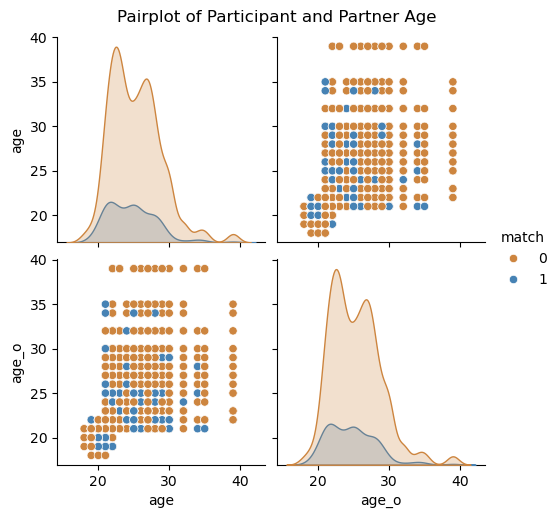

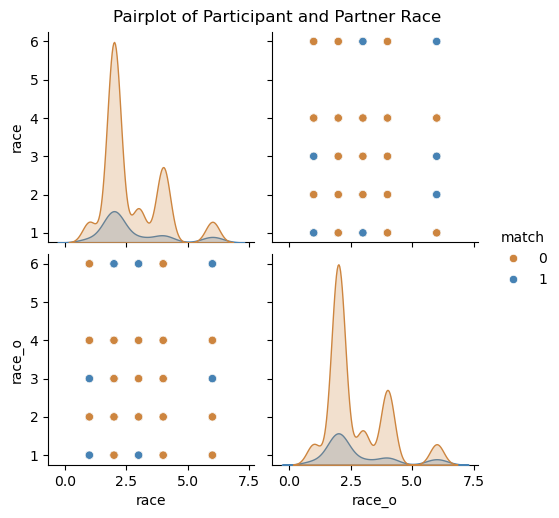

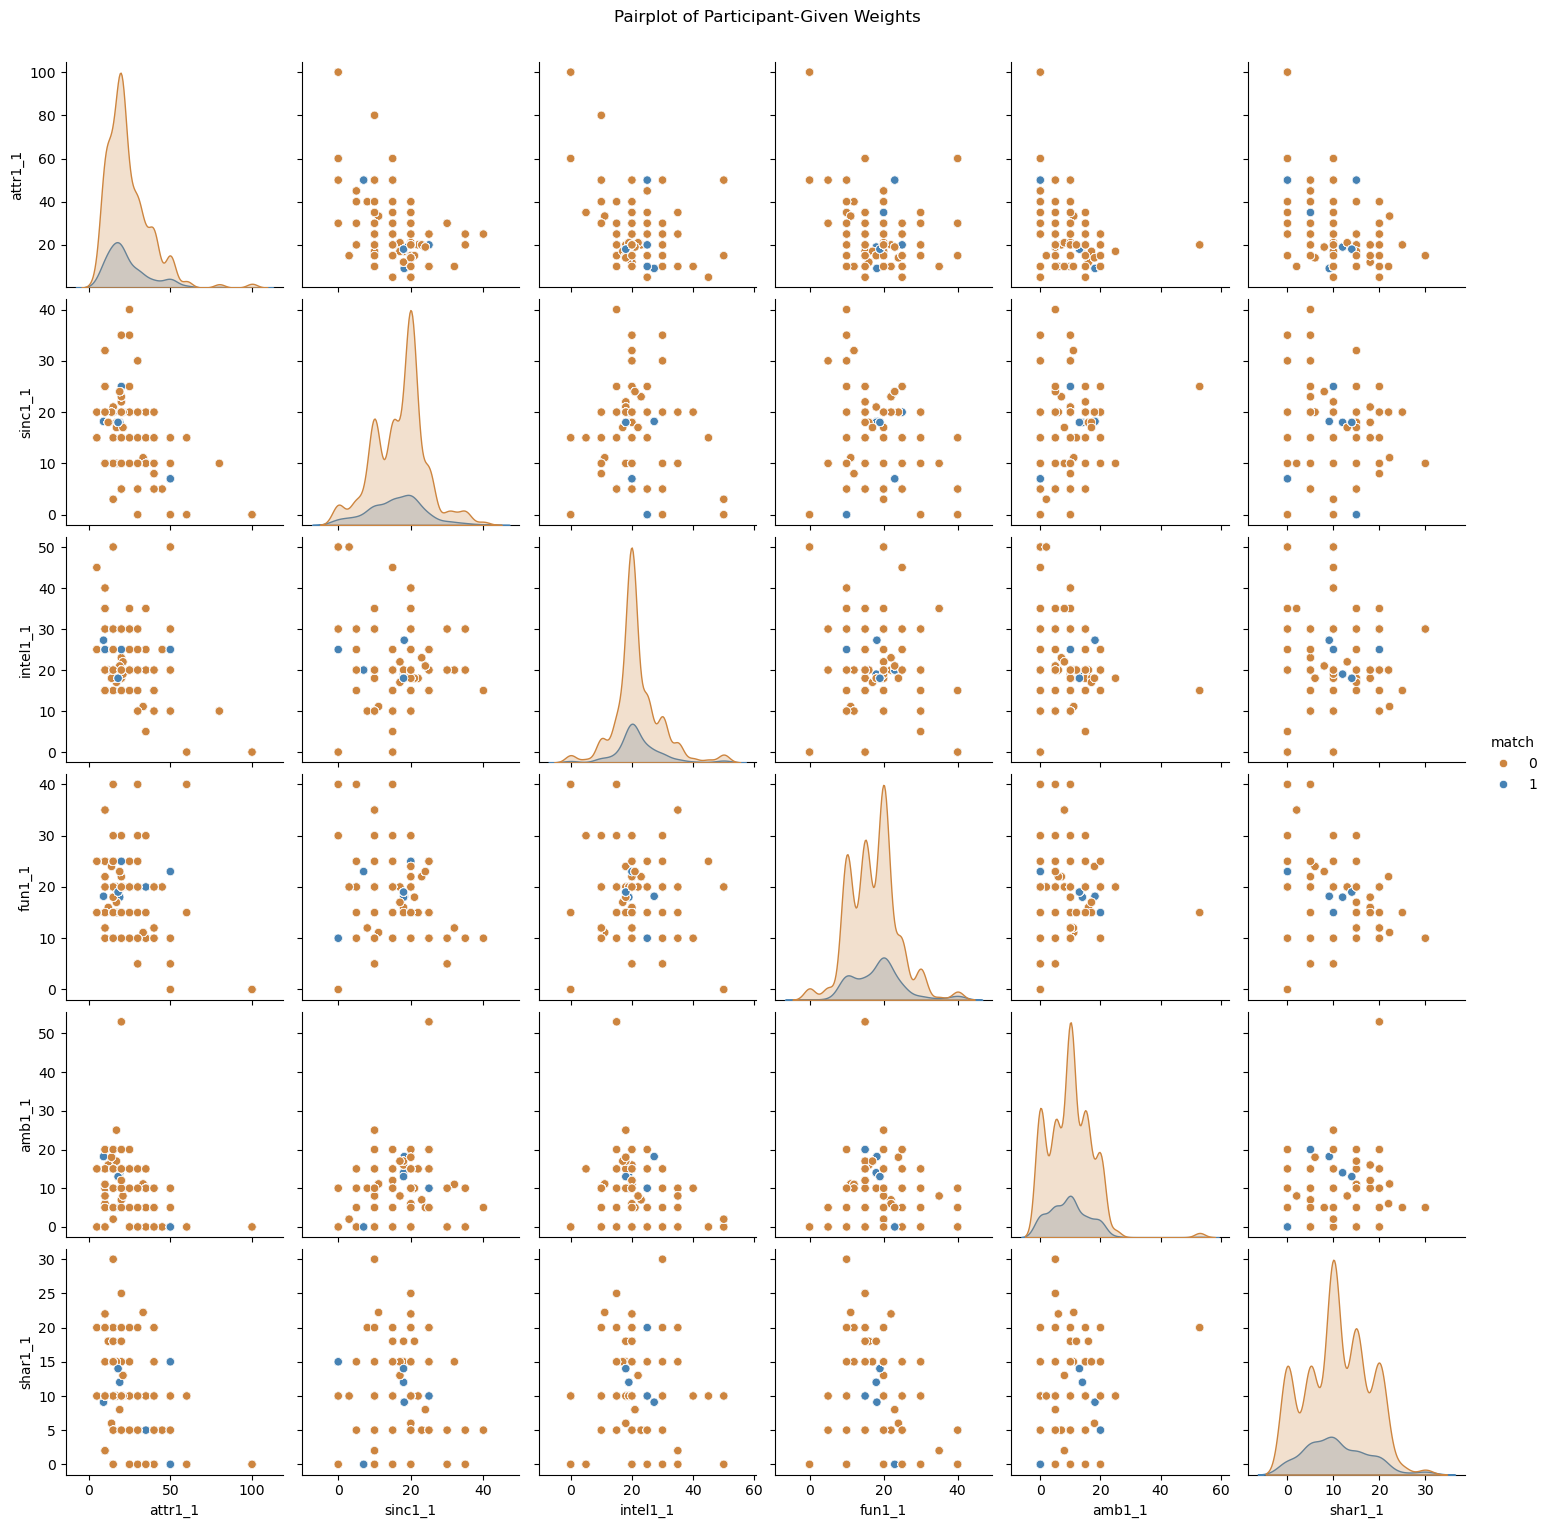

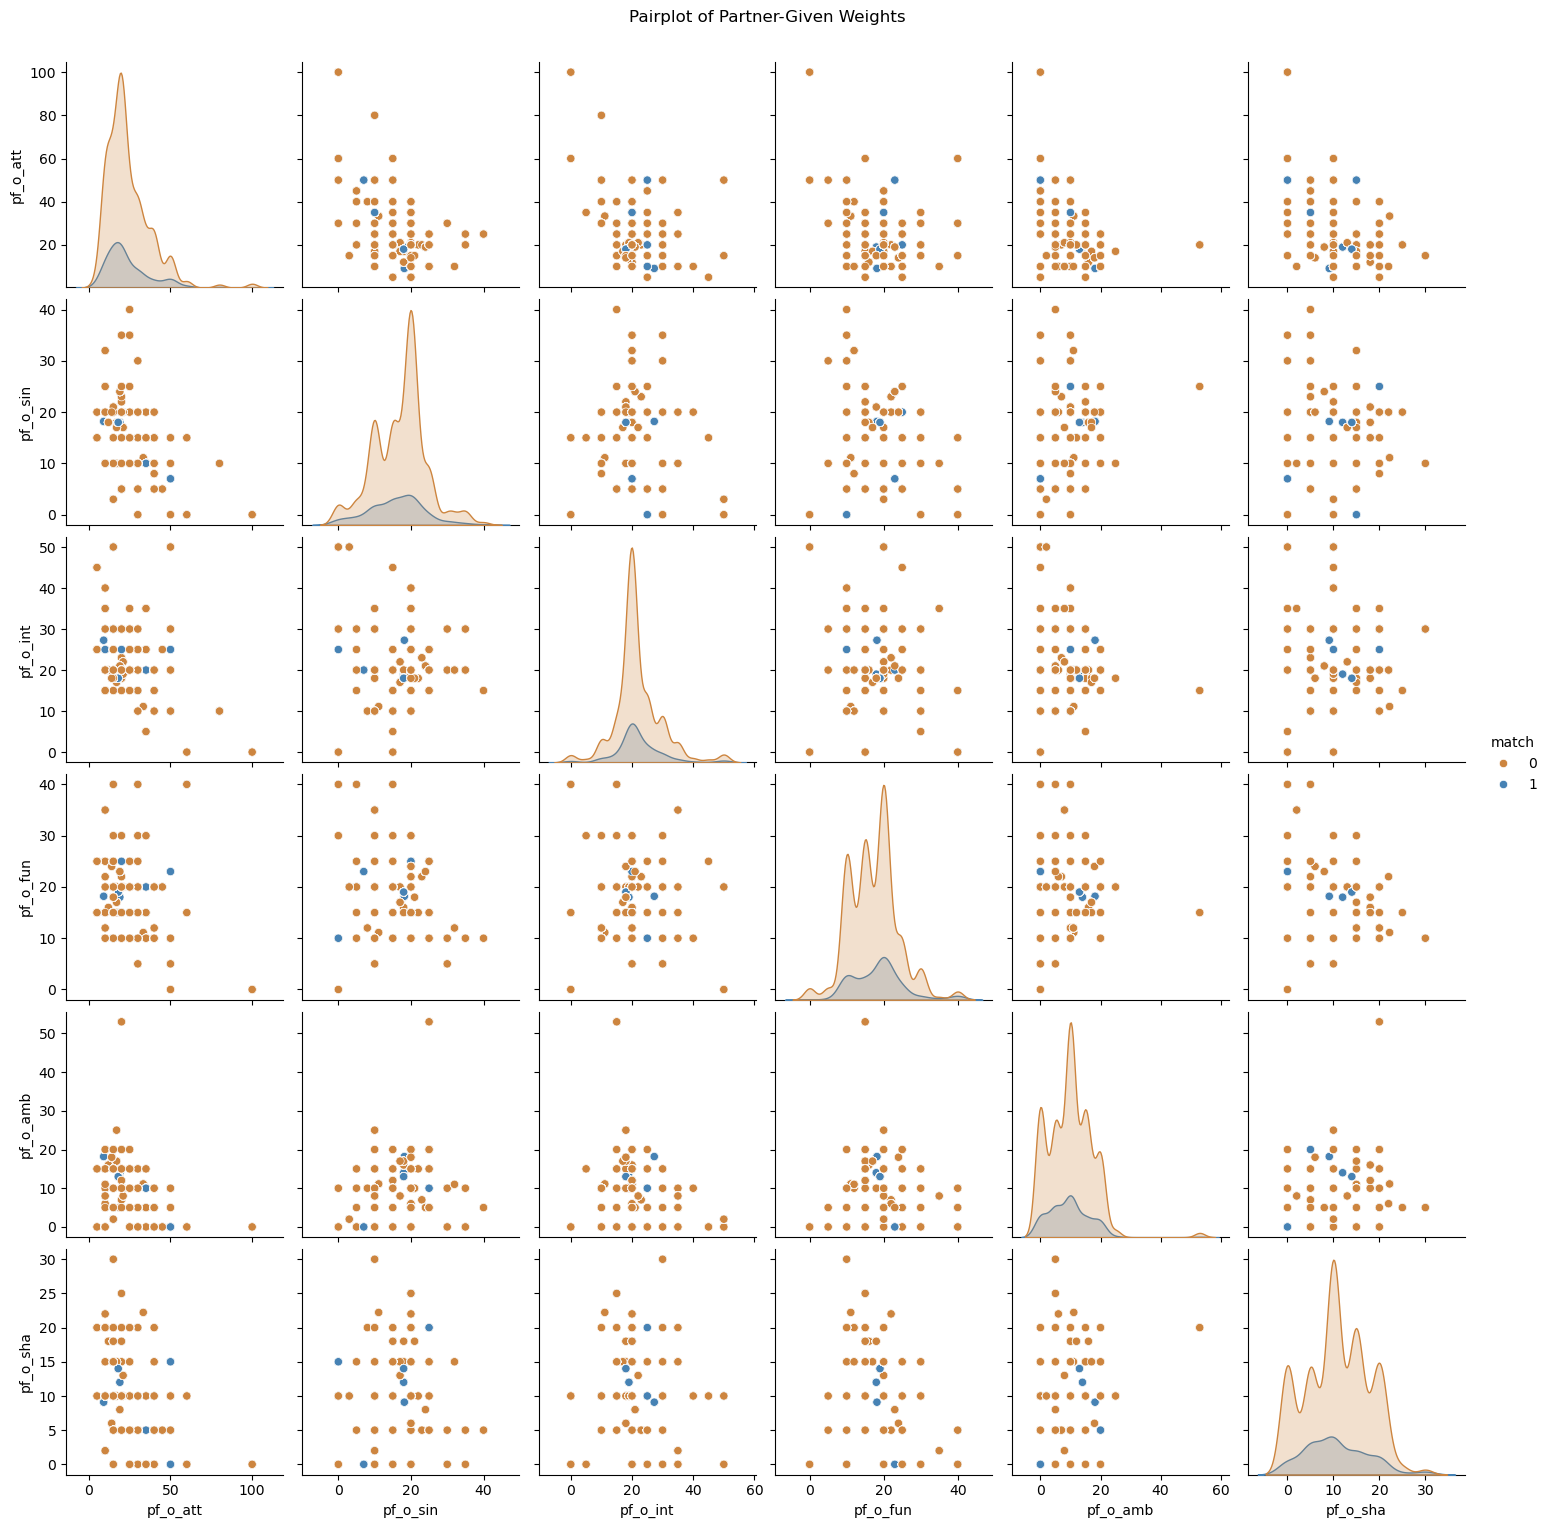

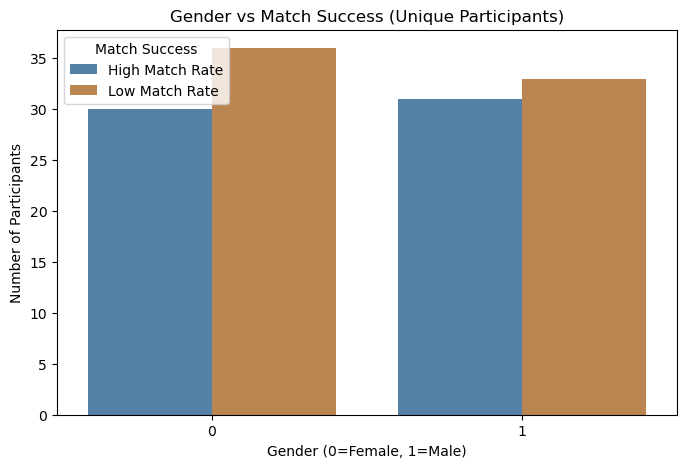

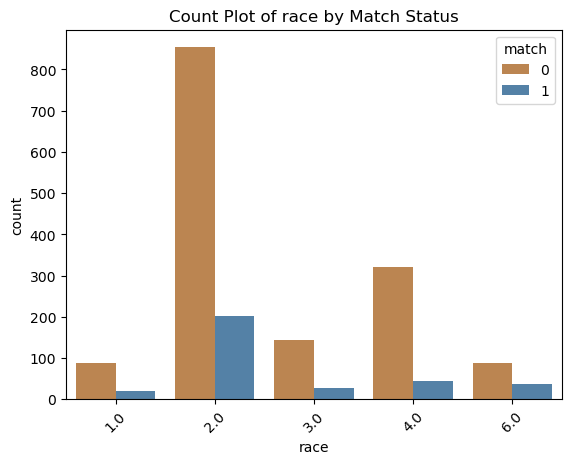

In [5]:

custom_palette = {'Low Match Rate': 'peru', 'High Match Rate': 'steelblue'}

pairplot_palette = {0: 'peru', 1: 'steelblue'}


pairplot_age = ['age', 'age_o']
if all(col in dating_full.columns for col in pairplot_age):
    sns.pairplot(dating_full, vars=pairplot_age, hue='match', palette=pairplot_palette)
    plt.suptitle('Pairplot of Participant and Partner Age', y=1.02)
    plt.show()

pairplot_race = ['race', 'race_o']
if all(col in dating_full.columns for col in pairplot_race):
    sns.pairplot(dating_full, vars=pairplot_race, hue='match', palette=pairplot_palette)
    plt.suptitle('Pairplot of Participant and Partner Race', y=1.02)
    plt.show()

pairplot1 = ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1','amb1_1','shar1_1']
if all(col in dating_full.columns for col in pairplot1):
    sns.pairplot(dating_full, vars=pairplot1, hue='match', palette=pairplot_palette)
    plt.suptitle('Pairplot of Participant-Given Weights', y=1.02)
    plt.show()

pairplot2 = ['pf_o_att','pf_o_sin','pf_o_int','pf_o_fun','pf_o_amb','pf_o_sha']
if all(col in dating_full.columns for col in pairplot2):
    sns.pairplot(dating_full, vars=pairplot2, hue='match', palette=pairplot_palette)
    plt.suptitle('Pairplot of Partner-Given Weights', y=1.02)
    plt.show()

# Count plots for categorical variables
categorical_for_counts = ['gender', 'race']

for cat_var in categorical_for_counts:
    if cat_var in dating_full.columns:
        
        if cat_var == 'gender':
            # Create unique participant dataset
            dating_unique = dating_full.drop_duplicates(subset=['iid']).copy()
            
            # Calculate match success at participant level
            participant_match_stats = dating_full.groupby('iid').agg({
                'gender': 'first',
                'match': 'mean'  # Match rate for this participant
            }).reset_index()
            
            # Create binary: above/below median match rate
            median_rate = participant_match_stats['match'].median()
            participant_match_stats['match_category'] = participant_match_stats['match'].apply(
                lambda x: 'High Match Rate' if x > median_rate else 'Low Match Rate'
            )
            
            # Create corrected count plot
            plt.figure(figsize=(8, 5))
            sns.countplot(data=participant_match_stats, x='gender', hue='match_category', palette=custom_palette)
            plt.title('Gender vs Match Success (Unique Participants)')
            plt.xlabel('Gender (0=Female, 1=Male)')
            plt.ylabel('Number of Participants')
            plt.legend(title='Match Success')
            plt.show()
            
        else:
            # race plot uses numeric match values (0/1)
            plt.figure()
            sns.countplot(data=dating_full, x=cat_var, hue='match', palette=pairplot_palette)
            plt.title(f'Count Plot of {cat_var} by Match Status')
            plt.xticks(rotation=45)
            plt.show()

## Data Prep For Model A: Demographic Predictors

Model A examines whether basic demographic variables can predict match outcomes.

Predictors:
- Participant age
- Partner age
- Participant race
- Partner race

This model is a baseline to see how much information demographics provide on their own.


In [6]:
# Demographic predictors for Model A
demo_vars = ['age', 'age_o', 'race', 'race_o']

X = dating_model[demo_vars].copy()
y = dating_model['match']

print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")
print("\nFeatures in X:")
for i, col in enumerate(X.columns):
    print(f"  {i+1:2d}. {col}")


X shape: (864, 4)
y shape: (864,)

Features in X:
   1. age
   2. age_o
   3. race
   4. race_o


## Train–Test Split

The dataset is split into training (75%) and testing (25%) sets using stratification on the match outcome.  
Stratification keeps the base rate of matches in both sets, which is important due to class imbalance.


In [7]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11, stratify=y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=11, stratify=y
)

print(f"\nTraining set: X={X_train.shape}, match rate={y_train.mean():.3f}")
print(f"Test set: X={X_test.shape}, match rate={y_test.mean():.3f}")



Training set: X=(648, 4), match rate=0.184
Test set: X=(216, 4), match rate=0.185


## Model A1: Lasso Logistic Regression (L1)

Lasso regularization encourages sparsity by shrinking weak predictors to zero.  
This model helps identify whether *any* demographic variables meaningfully contribute to predicting matches.

## Model A2: Ridge Logistic Regression (L2)

Ridge regularization penalizes large coefficients without forcing them to zero.  
This model tests whether demographic predictors jointly contribute small but meaningful effects.


MODEL A: Participant Weights
MODEL A1: LASSO LOGISTIC REGRESSION CV
Model A1 Testing Accuracy: 0.8148
Predicted matches: 0 out of 216

Confusion Matrix:
True Negatives: 176 | False Positives: 0
False Negatives: 40 | True Positives: 0

Model A1 Classification Report:
              precision    recall  f1-score   support

    No Match       0.81      1.00      0.90       176
       Match       0.00      0.00      0.00        40

    accuracy                           0.81       216
   macro avg       0.41      0.50      0.45       216
weighted avg       0.66      0.81      0.73       216



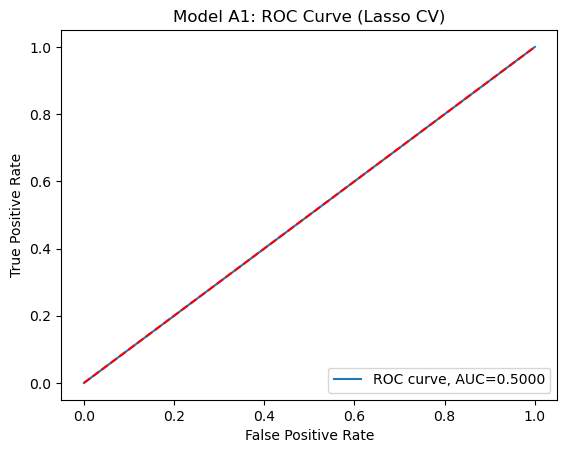

Model A1 AUC Score: 0.5000


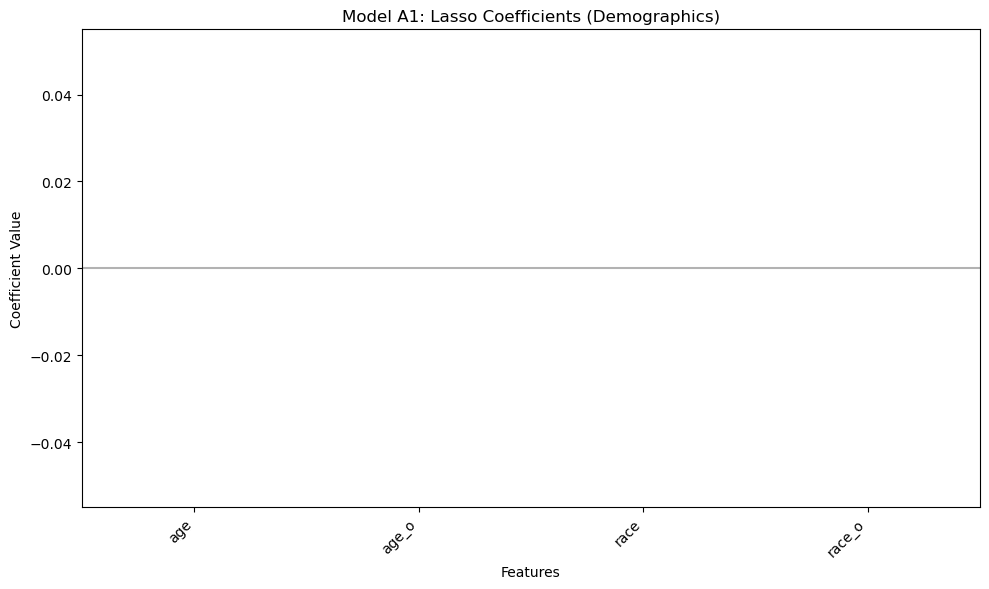


Model A1 Coefficients:
age: 0.0000
age_o: 0.0000
race: 0.0000
race_o: 0.0000
MODEL A2: RIDGE LOGISTIC REGRESSION CV
Model A2 Testing Accuracy: 0.8194
Predicted matches: 3 out of 216

Confusion Matrix:
True Negatives: 175 | False Positives: 1
False Negatives: 38 | True Positives: 2

Model A2 Classification Report:
              precision    recall  f1-score   support

    No Match       0.82      0.99      0.90       176
       Match       0.67      0.05      0.09        40

    accuracy                           0.82       216
   macro avg       0.74      0.52      0.50       216
weighted avg       0.79      0.82      0.75       216



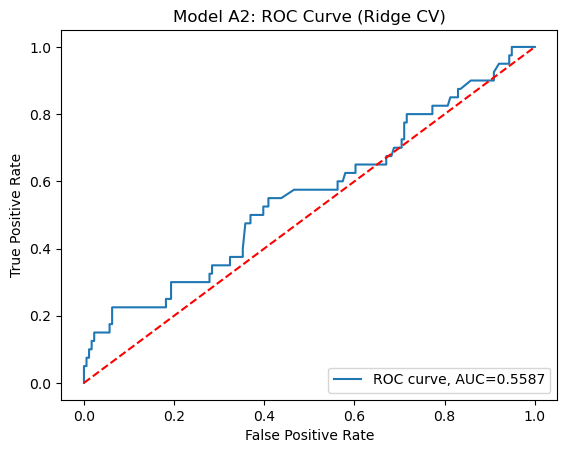

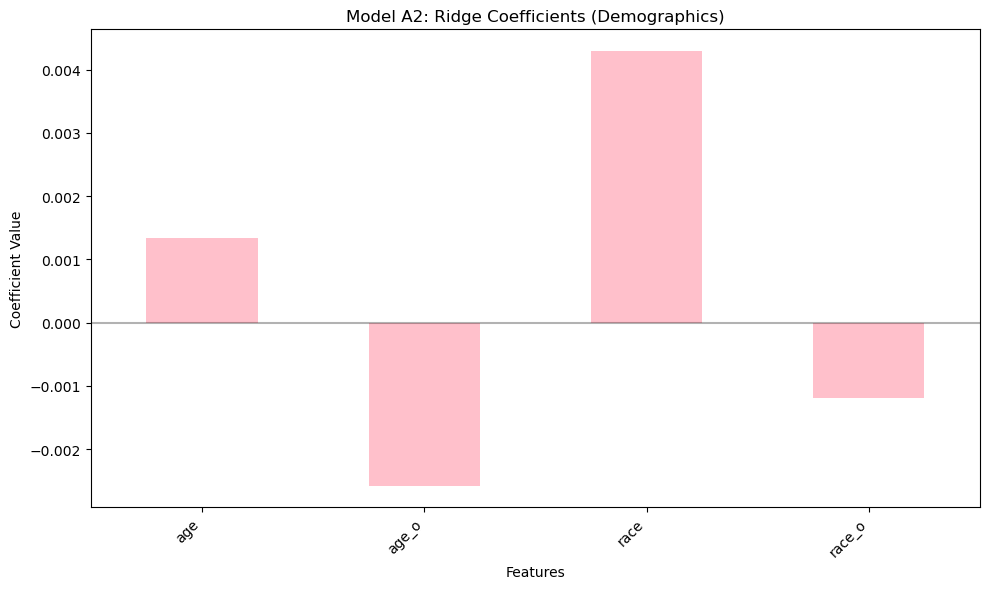


Model A2 Coefficients:
age: 0.0013
age_o: -0.0026
race: 0.0043
race_o: -0.0012


In [8]:

# MODEL A


print("MODEL A: Participant Weights")

class_names = ['No Match', 'Match']

# Model A uses ONLY demographic variables already in X_train and X_test
model_a_cols = demo_vars
X_train_a = X_train[model_a_cols]
X_test_a = X_test[model_a_cols]



# MODEL A1: Lasso Logistic Regression CV


print("MODEL A1: LASSO LOGISTIC REGRESSION CV")

logreg_a1 = LogisticRegressionCV(
    cv=5,
    penalty='l1',
    solver='saga',
    random_state=16,
    max_iter=5000,
    class_weight='balanced',
    tol=0.01
)
logreg_a1.fit(X_train_a, y_train)

test_accuracy_a1 = logreg_a1.score(X_test_a, y_test)
print(f"Model A1 Testing Accuracy: {test_accuracy_a1:.4f}")

test_pred_a1 = logreg_a1.predict(X_test_a)
print(f"Predicted matches: {test_pred_a1.sum()} out of {len(test_pred_a1)}")

test_cm_a1 = confusion_matrix(y_test, test_pred_a1)
print(f"\nConfusion Matrix:")
print(f"True Negatives: {test_cm_a1[0,0]} | False Positives: {test_cm_a1[0,1]}")
print(f"False Negatives: {test_cm_a1[1,0]} | True Positives: {test_cm_a1[1,1]}")

print("\nModel A1 Classification Report:")
print(classification_report(y_test, test_pred_a1, target_names=class_names, zero_division=0))

test_pprob_a1 = logreg_a1.predict_proba(X_test_a)
fpr_a1, tpr_a1, _ = roc_curve(y_test, test_pprob_a1[:, 1])
auc_a1 = roc_auc_score(y_test, test_pprob_a1[:, 1])

plt.plot(fpr_a1, tpr_a1, label=f"ROC curve, AUC={auc_a1:.4f}")
plt.plot([0, 1], [0, 1], 'r--')
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model A1: ROC Curve (Lasso CV)')
plt.show()

print(f"Model A1 AUC Score: {auc_a1:.4f}")

coefficients_a1 = pd.Series(logreg_a1.coef_[0], index=model_a_cols)
plt.figure(figsize=(10, 6))
coefficients_a1.plot(
    kind='bar',
    color='pink'   
)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.title('Model A1: Lasso Coefficients (Demographics)')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"\nModel A1 Coefficients:")
for name, coef in coefficients_a1.items():
    print(f"{name}: {coef:.4f}")



# MODEL A2: RIDGE


print("MODEL A2: RIDGE LOGISTIC REGRESSION CV")

logreg_a2 = LogisticRegressionCV(
    cv=5,
    penalty='l2',
    random_state=16,
    max_iter=5000,
    class_weight='balanced',
    tol=0.01
)
logreg_a2.fit(X_train_a, y_train)

test_accuracy_a2 = logreg_a2.score(X_test_a, y_test)
print(f"Model A2 Testing Accuracy: {test_accuracy_a2:.4f}")

test_pred_a2 = logreg_a2.predict(X_test_a)
print(f"Predicted matches: {test_pred_a2.sum()} out of {len(test_pred_a2)}")

test_cm_a2 = confusion_matrix(y_test, test_pred_a2)
print(f"\nConfusion Matrix:")
print(f"True Negatives: {test_cm_a2[0,0]} | False Positives: {test_cm_a2[0,1]}")
print(f"False Negatives: {test_cm_a2[1,0]} | True Positives: {test_cm_a2[1,1]}")

print("\nModel A2 Classification Report:")
print(classification_report(y_test, test_pred_a2, target_names=class_names, zero_division=0))

test_pprob_a2 = logreg_a2.predict_proba(X_test_a)
fpr_a2, tpr_a2, _ = roc_curve(y_test, test_pprob_a2[:, 1])
auc_a2 = roc_auc_score(y_test, test_pprob_a2[:, 1])

plt.plot(fpr_a2, tpr_a2, label=f"ROC curve, AUC={auc_a2:.4f}")
plt.plot([0, 1], [0, 1], 'r--')
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model A2: ROC Curve (Ridge CV)')
plt.show()

coefficients_a2 = pd.Series(logreg_a2.coef_[0], index=model_a_cols)

plt.figure(figsize=(10, 6))
coefficients_a2.plot(
    kind='bar',
    color='pink'
)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.title('Model A2: Ridge Coefficients (Demographics)')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


print(f"\nModel A2 Coefficients:")
for name, coef in coefficients_a2.items():
    print(f"{name}: {coef:.4f}")


## Data Prep For Model B: Preference Weight Predictors

Model B focuses on stated dating theories, using 100-point preference weights.

Predictors include:
- Participant preference weights
- Partner preference weights

The same train/test split is reused for consistency with Model A.


In [9]:
# EXPLICIT Model B predictors
model_b_cols = [
    'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1',
    'pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha'
]

X_full_B = dating_model[model_b_cols]

# Use SAME train/test split indices
X_train_b = X_full_B.loc[X_train.index]
X_test_b  = X_full_B.loc[X_test.index]

print(f"Model B uses {len(model_b_cols)} rating variables:")
print(model_b_cols)

Model B uses 12 rating variables:
['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1', 'pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha']


## Model B1: Lasso Logistic Regression (Preferences)

This model tests whether specific preference weights are predictive of match outcomes.

Lasso regularization will highlight which preference weights are most informative by shrinking weaker predictors toward zero.


## Model B2: Ridge Logistic Regression (Preferences)

Ridge regularization shows the predictive signal of all preference variables.  
Comparing Ridge and Lasso results might help distinguish actual predictors from noise.

MODEL B1: LASSO LOGISTIC REGRESSION CV
Model B1 Testing Accuracy: 0.6435
Predicted matches: 93 out of 216

Confusion Matrix:
True Negatives: 111 | False Positives: 65
False Negatives: 12 | True Positives: 28

Model B1 Classification Report:
              precision    recall  f1-score   support

    No Match       0.90      0.63      0.74       176
       Match       0.30      0.70      0.42        40

    accuracy                           0.64       216
   macro avg       0.60      0.67      0.58       216
weighted avg       0.79      0.64      0.68       216



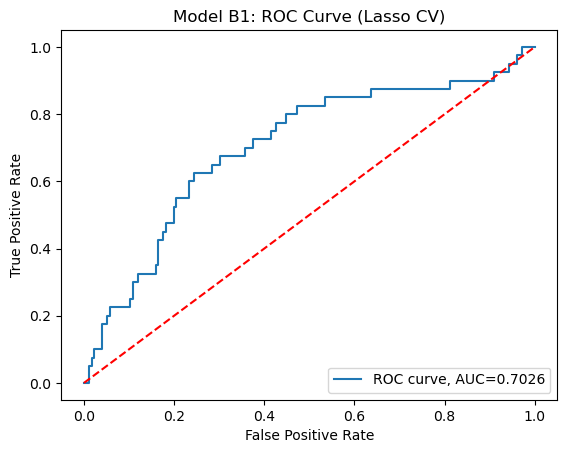

Model B1 AUC Score: 0.7026


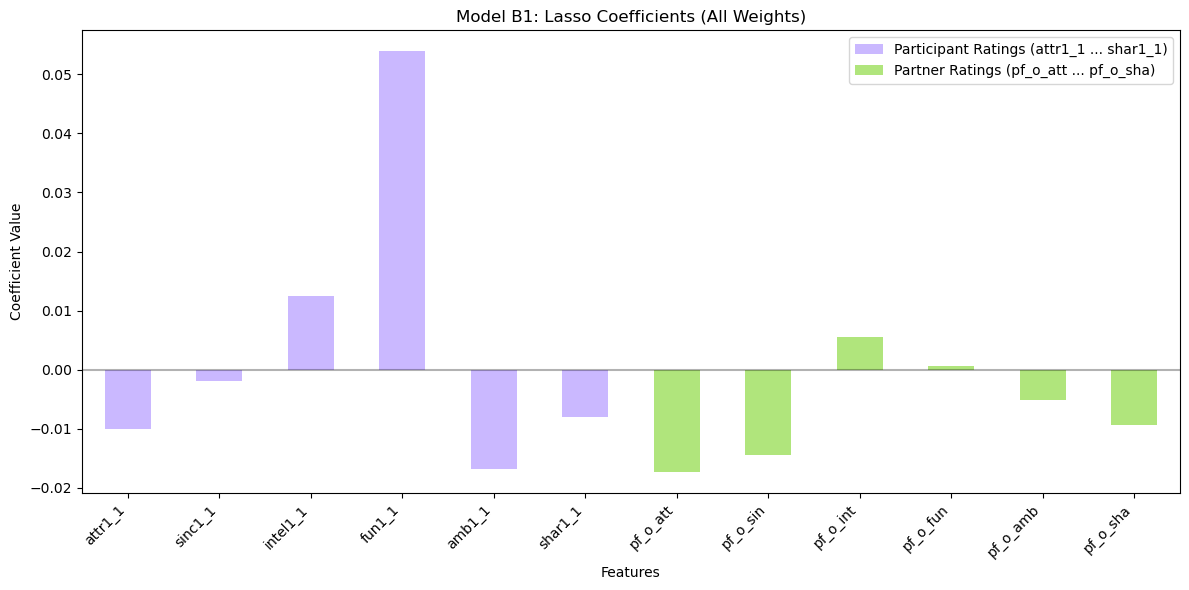


Model B1 Coefficients:
attr1_1: -0.0100
sinc1_1: -0.0020
intel1_1: 0.0124
fun1_1: 0.0539
amb1_1: -0.0169
shar1_1: -0.0081
pf_o_att: -0.0173
pf_o_sin: -0.0144
pf_o_int: 0.0054
pf_o_fun: 0.0007
pf_o_amb: -0.0052
pf_o_sha: -0.0094

Model B1 - Number of non-zero coefficients: 12 out of 12
MODEL B2: RIDGE LOGISTIC REGRESSION CV
Model B2 Testing Accuracy: 0.6528
Predicted matches: 91 out of 216

Confusion Matrix:
True Negatives: 113 | False Positives: 63
False Negatives: 12 | True Positives: 28

Model B2 Classification Report:
              precision    recall  f1-score   support

    No Match       0.90      0.64      0.75       176
       Match       0.31      0.70      0.43        40

    accuracy                           0.65       216
   macro avg       0.61      0.67      0.59       216
weighted avg       0.79      0.65      0.69       216



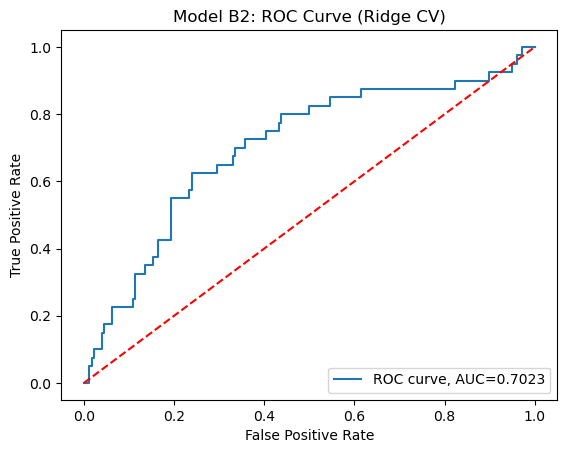

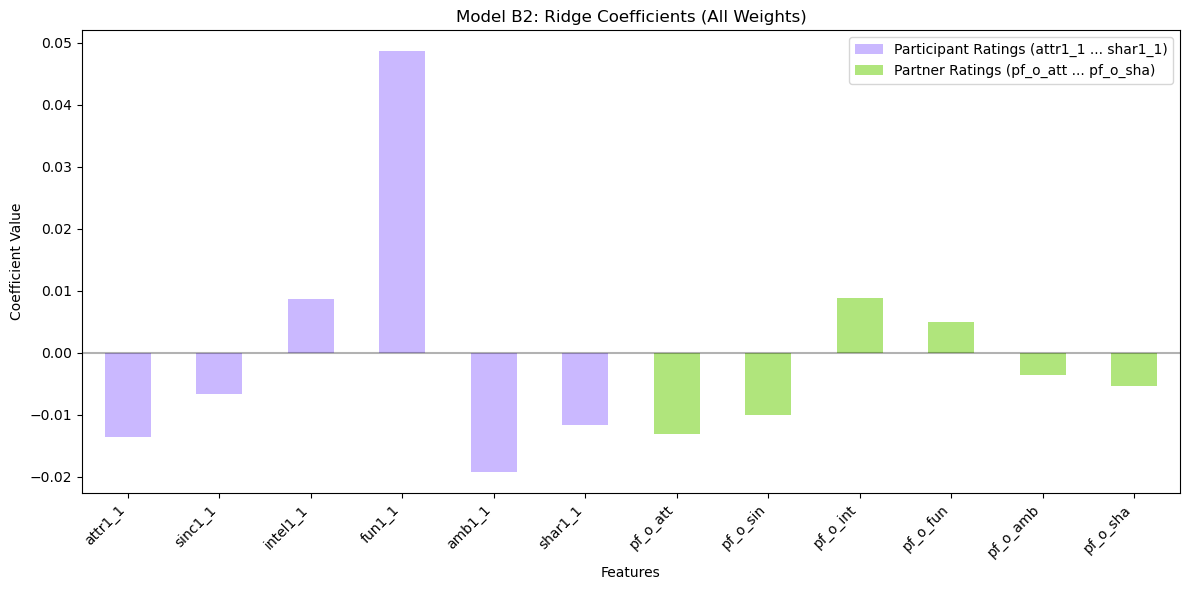


Model B2 Coefficients:
attr1_1: -0.0135
sinc1_1: -0.0066
intel1_1: 0.0087
fun1_1: 0.0486
amb1_1: -0.0192
shar1_1: -0.0116
pf_o_att: -0.0131
pf_o_sin: -0.0100
pf_o_int: 0.0088
pf_o_fun: 0.0049
pf_o_amb: -0.0036
pf_o_sha: -0.0054


In [10]:

# MODEL B1: LASSO


print("MODEL B1: LASSO LOGISTIC REGRESSION CV")

logreg_b1 = LogisticRegressionCV(
    cv=5,
    penalty='l1',
    solver='saga',
    random_state=16,
    max_iter=5000,
    class_weight='balanced',
    tol=0.01
)

logreg_b1.fit(X_train_b, y_train)

test_accuracy_b1 = logreg_b1.score(X_test_b, y_test)
print(f"Model B1 Testing Accuracy: {test_accuracy_b1:.4f}")

test_pred_b1 = logreg_b1.predict(X_test_b)
print(f"Predicted matches: {test_pred_b1.sum()} out of {len(test_pred_b1)}")

test_cm_b1 = confusion_matrix(y_test, test_pred_b1)
print(f"\nConfusion Matrix:")
print(f"True Negatives: {test_cm_b1[0,0]} | False Positives: {test_cm_b1[0,1]}")
print(f"False Negatives: {test_cm_b1[1,0]} | True Positives: {test_cm_b1[1,1]}")

print("\nModel B1 Classification Report:")
print(classification_report(y_test, test_pred_b1, target_names=class_names, zero_division=0))

test_pprob_b1 = logreg_b1.predict_proba(X_test_b)
fpr_b1, tpr_b1, _ = roc_curve(y_test, test_pprob_b1[:, 1])
auc_b1 = roc_auc_score(y_test, test_pprob_b1[:, 1])

plt.plot(fpr_b1, tpr_b1, label=f"ROC curve, AUC={auc_b1:.4f}")
plt.plot([0, 1], [0, 1], 'r--')
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model B1: ROC Curve (Lasso CV)')
plt.show()

print(f"Model B1 AUC Score: {auc_b1:.4f}")

pastel_lavender = "#cab8ff"
pastel_mint = "#B0E57C"

participant_cols = [
    'attr1_1', 'sinc1_1', 'intel1_1',
    'fun1_1', 'amb1_1', 'shar1_1'
]

partner_cols = [
    'pf_o_att', 'pf_o_sin', 'pf_o_int',
    'pf_o_fun', 'pf_o_amb', 'pf_o_sha'
]

color_map_b1 = [
    pastel_lavender if col in participant_cols else pastel_mint
    for col in model_b_cols
]
coefficients_b1 = pd.Series(logreg_b1.coef_[0], index=model_b_cols)

plt.figure(figsize=(12, 6))
coefficients_b1.plot(kind='bar', color=color_map_b1)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.title('Model B1: Lasso Coefficients (All Weights)')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')

# Legend
from matplotlib.patches import Patch
legend_handles = [
    Patch(facecolor=pastel_lavender, label='Participant Ratings (attr1_1 ... shar1_1)'),
    Patch(facecolor=pastel_mint, label='Partner Ratings (pf_o_att ... pf_o_sha)')
]
plt.legend(handles=legend_handles, loc='upper right')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


print(f"\nModel B1 Coefficients:")
for name, coef in coefficients_b1.items():
    if coef == 0:
        print(f"{name}: {coef:.4f} (zero - removed by Lasso)")
    else:
        print(f"{name}: {coef:.4f}")

print(f"\nModel B1 - Number of non-zero coefficients: {(coefficients_b1 != 0).sum()} out of {len(coefficients_b1)}")



# MODEL B2: RIDGE


print("MODEL B2: RIDGE LOGISTIC REGRESSION CV")

logreg_b2 = LogisticRegressionCV(
    cv=5,
    penalty='l2',
    random_state=16,
    max_iter=5000,
    class_weight='balanced',
    tol=0.01
)

logreg_b2.fit(X_train_b, y_train)

test_accuracy_b2 = logreg_b2.score(X_test_b, y_test)
print(f"Model B2 Testing Accuracy: {test_accuracy_b2:.4f}")

test_pred_b2 = logreg_b2.predict(X_test_b)
print(f"Predicted matches: {test_pred_b2.sum()} out of {len(test_pred_b2)}")

test_cm_b2 = confusion_matrix(y_test, test_pred_b2)
print(f"\nConfusion Matrix:")
print(f"True Negatives: {test_cm_b2[0,0]} | False Positives: {test_cm_b2[0,1]}")
print(f"False Negatives: {test_cm_b2[1,0]} | True Positives: {test_cm_b2[1,1]}")

print("\nModel B2 Classification Report:")
print(classification_report(y_test, test_pred_b2, target_names=class_names, zero_division=0))

test_pprob_b2 = logreg_b2.predict_proba(X_test_b)
fpr_b2, tpr_b2, _ = roc_curve(y_test, test_pprob_b2[:, 1])
auc_b2 = roc_auc_score(y_test, test_pprob_b2[:, 1])

plt.plot(fpr_b2, tpr_b2, label=f"ROC curve, AUC={auc_b2:.4f}")
plt.plot([0, 1], [0, 1], 'r--')
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model B2: ROC Curve (Ridge CV)')
plt.show()

color_map_b2 = color_map_b1  
coefficients_b2 = pd.Series(logreg_b2.coef_[0], index=model_b_cols)

plt.figure(figsize=(12, 6))
coefficients_b2.plot(kind='bar', color=color_map_b2)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.title('Model B2: Ridge Coefficients (All Weights)')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')

# Legend
legend_handles = [
    Patch(facecolor=pastel_lavender, label='Participant Ratings (attr1_1 ... shar1_1)'),
    Patch(facecolor=pastel_mint, label='Partner Ratings (pf_o_att ... pf_o_sha)')
]
plt.legend(handles=legend_handles, loc='upper right')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"\nModel B2 Coefficients:")
for name, coef in coefficients_b2.items():
    print(f"{name}: {coef:.4f}")